# Autoencoder for credit card detection (Pytorch)

The objective of this exercice is to build a model able to detect fraudulous credit card transactions among normal transactions. For this we train a special type of neural network called autoencoder. This network has as many input nodes as output nodes, and several hidden layers with, usually lower dimensions. 

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) (big file: 144 MB). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All 30 features in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

The dataset also contains the class of event: 0 = normal transaction; 1 = fraudulous transaction.

## Initialize

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import sys
print(sys.version)
print(torch.version)
print('cuda:',torch.version.cuda)

# Choose cpu/gpu
use_gpu=0
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")


3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
<module 'torch.version' from 'C:\\Users\\Pierre\\anaconda3\\Lib\\site-packages\\torch\\version.py'>
cuda: None

Run on cpu


## 1. Explore Data

a) Download the dataset and load it in a panda dataframe. Look at the first 10 examples.

b) Separate the data in two classes `normal` and `fraud`, then remove the class label from these datasets in order to conserve only the features.

c) Plot the first 5 features of both normal and fraud data (plotting all features is time consuming).

d) Split the `normal` dataset into a training and a test sample (each of same size).

After the last step you should have 3 datasets:
* normal data used for training
* normal data used for testing
* fraud data used for testing

In [15]:
#a)
df = pd.read_csv(r'C:\Users\Pierre\Downloads\archive (2)\creditcard.csv')
df.head(10)
df_n = df[df['Class']==0]
df_n = df_n.drop(columns=['Class'])
df_n.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [3]:
df_f = df[df['Class']==1]
df_f = df_f.drop(columns=['Class'])
df_f

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00


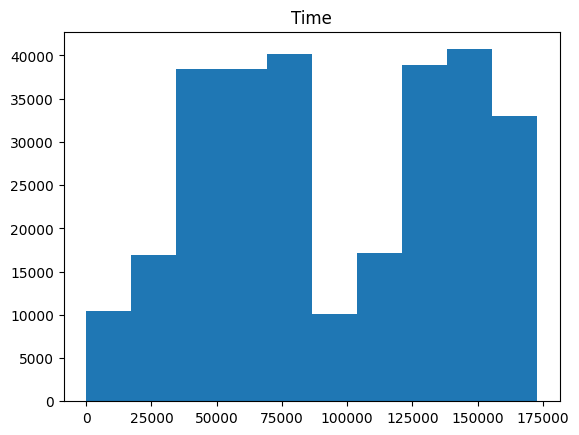

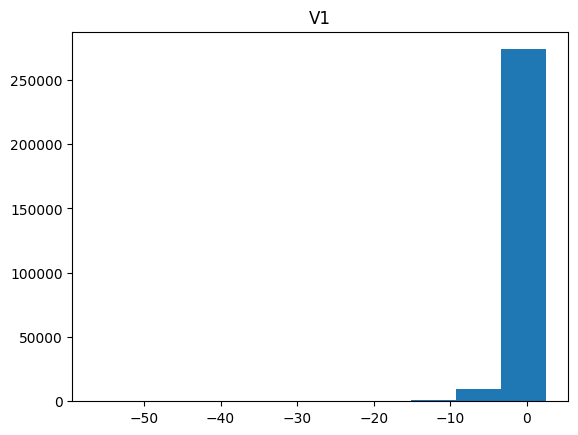

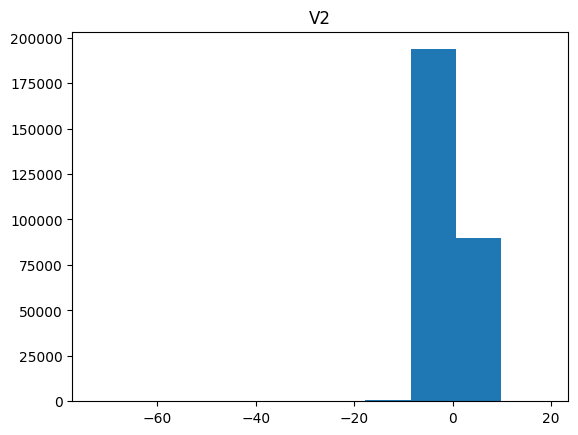

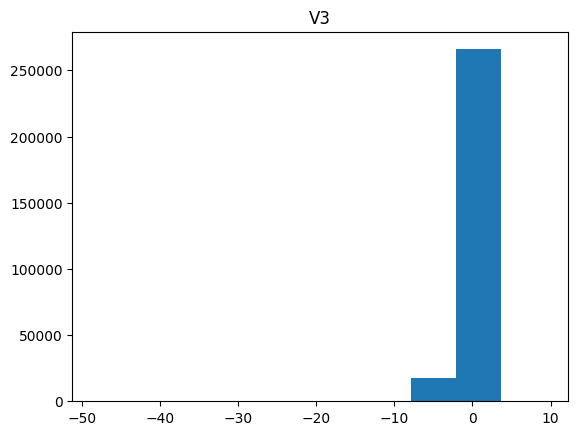

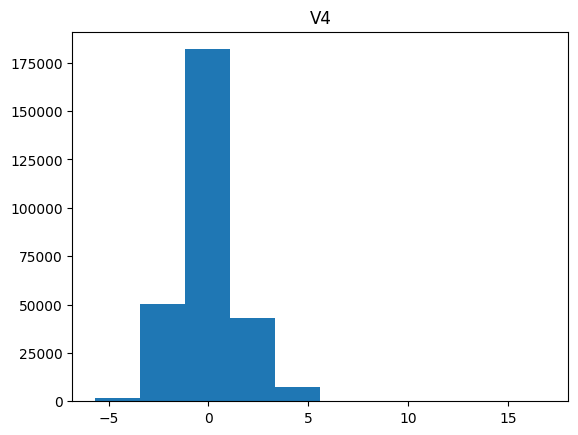

In [4]:
#b)
for i in range(5):
    plt.figure()
    plt.hist(df_n[df_n.columns.values[i]])
    plt.title(f'{df_n.columns.values[i]}')

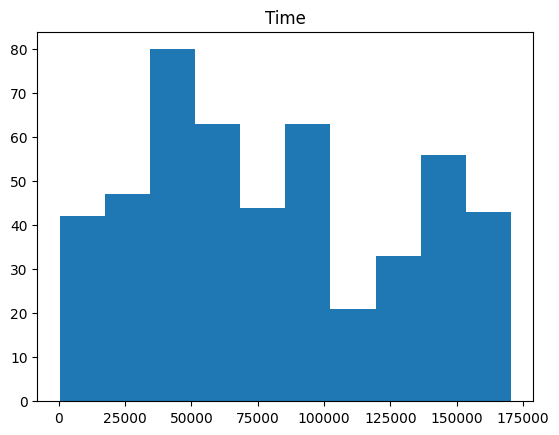

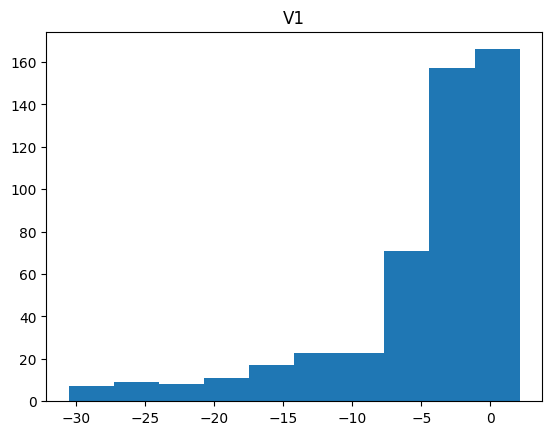

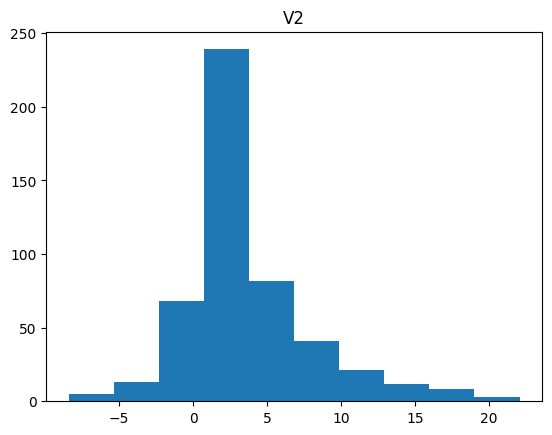

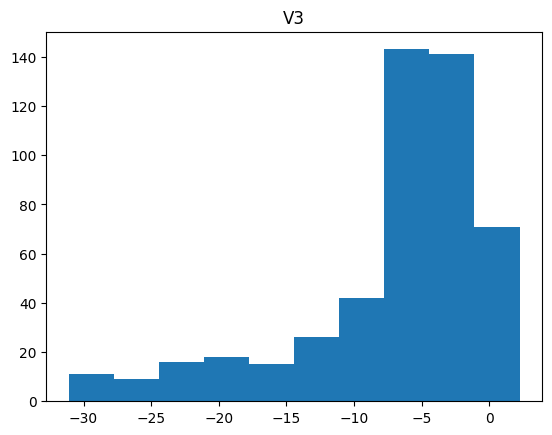

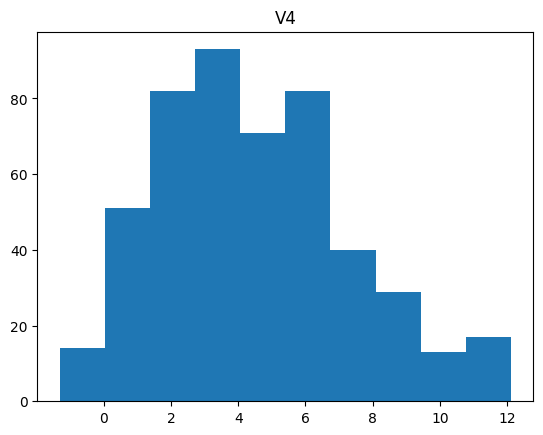

In [5]:
for i in range(5):
    plt.figure()
    plt.hist(df_f[df_f.columns.values[i]])
    plt.title(f'{df_f.columns.values[i]}')

In [6]:
#c)
proportion_part1 = 0.5

# Sélection aléatoire des indices pour la première partie
indices_part1 = df_n.sample(frac=proportion_part1, random_state=42).index

# Sélection des indices restants pour la deuxième partie
indices_part2 = df_n.index.difference(indices_part1)

# Diviser le DataFrame en deux parties
X_n_train = part1 = df_n.loc[indices_part1]
X_n_test = df_n.loc[indices_part2]

## 2. Rescale data

Since features have different range we apply a transformation to each feature. For this we  use the MinMaxScaler that scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one:

See: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

a) Fit and transform the training dataset using the scaler with the `fit_transform` method.

b) Apply the transformation on the tests samples using the `transform` method.

c) Plot the first 5 features of the normal and fraud test data and see how they changed.

In [7]:
scaler = MinMaxScaler()
Xn_train = scaler.fit_transform(X_n_train)
Xn_test = scaler.fit_transform(X_n_test)
Xf_test = scaler.fit_transform(df_f)


## 3. Partition training data

After all of this, it's important to partition the data. In order for your model to generalize well, you split the training data into two parts: a training and a validation set. You will train your model on 80% of the data and validate it on 20% of the remaining training data. 

In [16]:
proportion_part1 = 0.8
X = pd.DataFrame(Xn_train)
# Sélection aléatoire des indices pour la première partie
indices_part1 = X.sample(frac=proportion_part1, random_state=42).index

# Sélection des indices restants pour la deuxième partie
indices_part2 = X.index.difference(indices_part1)

# Diviser le DataFrame en deux parties
X_train = X.loc[indices_part1]
X_valid = X.loc[indices_part2]
X_train.shape

(113726, 30)

## 4. AutoEncoder model

Now we create the AutoEncoder model. 

Complete the network structure below using linear functions `nn.Linear(dim1,dim2)` (where `dim1` is the input dim of the layer and `dim2` the dimension of the layer output) and sigmoid activation functions `nn.Sigmoid()`:

a) in the encoding part create layers of dimension 30 (input) - 30 (hidden layer 1) - 25 (hidden layer 2) - 20 (latence space), each with a sigmoid activation function

b) in the decoding part create layers of dimension 25 (hidden layer 2) - 30 (hidden layer 1) - 30 (output) , where only the 1st layer has a sigmoid activation function

c) look at the forward function, what does it return ?


### Hyperparameters of the network

In [9]:
num_epochs = 200
batch_size = 2048
hidden_layer1 = 30
hidden_layer2 = 25
encoding_dim = 20

### AutoEncoder structure

In [10]:
input_dim = X_train.shape[1]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.Sigmoid(),
            nn.Linear(30, 25),
            nn.Sigmoid(),
            nn.Linear(25, 20),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 25),
            nn.Sigmoid(),
            nn.Linear(25, 30),
            nn.Linear(30, input_dim),
        )

    def forward(self, x):
        x = self.encoder(hx)
        x = self.decoder(x)
        return x

# Settings
if (use_gpu):
    model = autoencoder().cuda() # enable GPU
else:
    model = autoencoder()


## 5. Set the data loading utilities

We now call the [DataLoader](https://pytorch.org/docs/stable/data.html) constructors for the following datasets:
* normal data used for training
* normal data used for validation
* normal data used for testing
* fraud data used for testing

We shuffle the loading process of the train and validation datasets to make the learning process independent of data orderness, but the order of test datasets remains the same to examine whether we can handle unspecified bias order of inputs.

See how this is done below (you need to replace your own dataset names where appropriate).

In [11]:
# For training on normal samples
train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=X_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing on fraud examples (shuffle=False)
test_fraud_loader = torch.utils.data.DataLoader(dataset=Xf_test,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on unseen normal sample (shuffle=False)
test_normal_loader = torch.utils.data.DataLoader(dataset=Xn_test,
                                          batch_size=batch_size,
                                          shuffle=False)


## 6. Training on normal samples

Run the training of the network on the training sample. For this complete the code below by answering the following questions:

a) Choose the mean square error loss function. See https://pytorch.org/docs/master/nn.html#loss-functions

b) Select the Adam optimizer (= minimization) method with a learning rate of 0.001. See https://pytorch.org/docs/stable/optim.html.

c) Fill the validation step knowing that it is the same structure as the training step but without the minimization part (not needed for validation).

d) Record for each epoch the loss value calculated for the training and validation steps. Make a figure of the training and validation losses as a function of the number of epochs. Do the two curve agree ?


In [12]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Loss_train = []
Loss_valid = []
for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prepare model for training
    for data in train_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Loss_train.append(loss)
    

    ######################    
    # validate the model #
    ######################
    model.eval() # prepare model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)       
        Loss_valid.append(loss)
       
    



KeyError: 62997

## 7. Calculate autoencoder distances

Now we calculate the euclidean distance between the autoencoder input and output.

$$ \text{distance} = \sqrt{ ||x_{\text{input}} - x_{\text{output}}||^2} = \sqrt{ \sum_i (x^i_{\text{input}} - x^i_{\text{output}})^2}$$

a) See below how this is done for the normal test data, and do the same for the fraud test data.

b) Plot the histograms of the calculated distances of the normal and fraud test data. For better viewing choose a logarithmic scale for the y axis. Comment on the result.

In [ ]:
model.eval() # Sets the module in evaluation mode.
model.cpu()  # Moves all model parameters and buffers to the CPU to avoid out of memory

# Normal test dataset
#--------------------
test_normal_distance = []
for data in test_normal_loader:
    data = data.type(dtype).cpu().detach()
    output = model(data)
    test_normal_distance += torch.sqrt((torch.sum((data-output)**2,axis=1)))

# convert list to tensor
test_normal_distance = torch.FloatTensor(test_normal_distance)

# convert tensor to numpy array
test_normal_distance = test_normal_distance.numpy()

# Fraud test dataset
#-------------------

# FILL HERE #

## 8. Confusion matrix

Build a confusion matrix with a threshold on the distance such that 50% of fraud transactions are detected. What is the true positive rate in this case ? Is this threshold interesting ?

## 9. ROC Curve

Draw the ROC curve for the test sample.

## 10. Optimise the performance of the NN (optional)

Try the following:
* Change hyperparameters values
* Modify activation functions
* Add one or more layers
* Try [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
* ...

In [ ]:
model